In [40]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Plant Village",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 2153 files belonging to 3 classes.


In [4]:
class_name = dataset.class_names
class_name

['Potato_Early_Blight', 'Potato_Healthy', 'Potato_Late_blight']

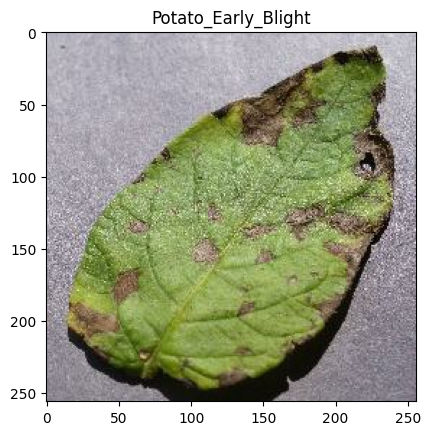

In [5]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[31].numpy().astype('uint8'))
    plt.title(class_name[label_batch[31].numpy()])

In [6]:
train_ds = dataset.take(54)
len(train_ds)

54

In [7]:
test_ds = dataset.skip(54) 
len(test_ds)

14

In [8]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [9]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [10]:
def get_dataset_partition_tf(ds, train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds= ds.shuffle(shuffle_size,seed=12)

    
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds

In [11]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [12]:
len(train_ds)

54

In [13]:
len(test_ds)

8

In [14]:
len(val_ds)

6

In [15]:

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
from tensorflow.keras.layers import Resizing,Rescaling
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

In [17]:
from tensorflow.keras.models import Sequential
data_augmentation = Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

In [18]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

C:\Users\vhsar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [22]:
model.fit(train_ds,
          epochs=10,
          batch_size = BATCH_SIZE,
          verbose=1,
          validation_data=val_ds
         )

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 546ms/step - accuracy: 0.4493 - loss: 0.9484 - val_accuracy: 0.7135 - val_loss: 0.8268
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 537ms/step - accuracy: 0.7009 - loss: 0.7258 - val_accuracy: 0.6875 - val_loss: 0.6966
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 546ms/step - accuracy: 0.7913 - loss: 0.5154 - val_accuracy: 0.8073 - val_loss: 0.4579
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 542ms/step - accuracy: 0.8206 - loss: 0.4449 - val_accuracy: 0.8802 - val_loss: 0.3529
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 533ms/step - accuracy: 0.8173 - loss: 0.4549 - val_accuracy: 0.9062 - val_loss: 0.2948
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 534ms/step - accuracy: 0.8976 - loss: 0.2611 - val_accuracy: 0.9271 - val_loss: 0.2030
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 595ms/step - accuracy: 0.8814 - loss: 0.3001 - val_accuracy: 0.9115 - val_loss: 0.2124
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 32s 581ms/step - accuracy: 0.9328 - loss: 0.2009 - val_accu

In [23]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - accuracy: 0.8983 - loss: 0.2898


In [59]:
pred = []
actual = []
confidence = []
for image_batch , labels_batch in test_ds.take(1):
    output = model.predict(image_batch)
    for j in labels_batch.numpy():
        actual.append(class_name[j])
        
for i in output:
    pred.append(class_name[np.argmax(i)])
    confidence.append(round(np.max(i)*100))
print(actual[5:10])
print(pred[5:10])
print(confidence[5:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
['Potato_Early_Blight', 'Potato_Early_Blight', 'Potato_Early_Blight', 'Potato_Late_blight', 'Potato_Late_blight']
['Potato_Early_Blight', 'Potato_Early_Blight', 'Potato_Early_Blight', 'Potato_Late_blight', 'Potato_Late_blight']
[92, 100, 100, 65, 94]


In [65]:

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


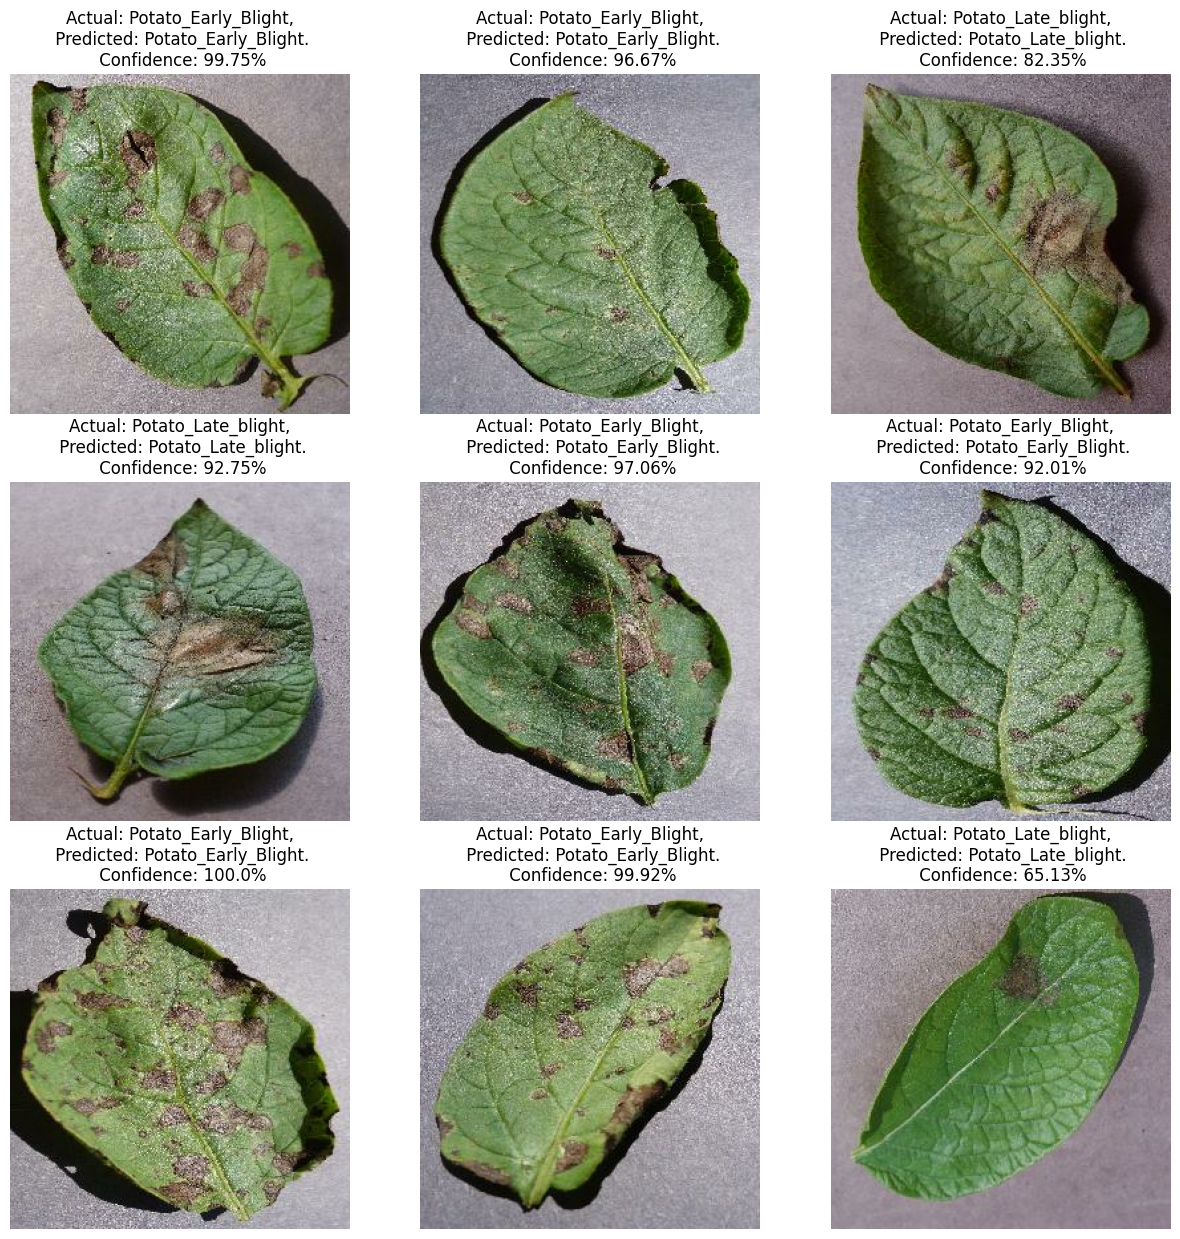

In [66]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [85]:
import os
os.listdir("../potato disease/Model/")

['1.keras']

In [82]:
import os
model_version=max([int(i) for i in os.listdir("../potato disease/Model/") + [0]])+1
model.save(f"../potato disease/Model/{model_version}.keras")

In [84]:
model_version=1
model.save(f"../potato disease/Model/{model_version}.keras")